# Sentiment Analysis of Reddit Posts

This Notebook will analyze the sentiment of Reddit posts from the modeled data. The goal is to see if there is a correlation between the sentiment of similar reddit communities, and to measure the morale and overall sentiment of each individual group.
I will be using the BERT model to analyze the sentiment of each post. The process will include:
1. Importing the data
2. Preprocessing the text [`selftext`]
3. BERT Tokenization
4. BERT Model
5. BERT Prediction
6. Analyze Results

Notes to self:

References:
https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=dCpvgG0vwXAZ

https://www.youtube.com/watch?v=QpzMWQvxXWk&t=1727s 

https://www.youtube.com/watch?v=ujId4ipkBio (Subjectivity and Polarity)

## Import Data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#NLKT
import re  
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud

#BERT
import bert
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tqdm import tqdm


In [110]:
#import data
text_data_df = pd.read_csv('./data/processed_data.csv')

text_data_df.head()

subreddit                                           selftext  \
0      Army  This was a convo I had with one of my buddies ...   
1      Army  BLUF: how do you overcome imposter syndrome?\n...   
2      Army  Long story short, my estranged (soon to be ex)...   
3      Army  \nMy husband is 35T, and just graduated AIT. W...   
4      Army  I could use some advice on going recruiting. I...   

                                               title link_flair_richtext  \
0  If you could create a new MRE based on a Fast ...                  []   
1                              how do you even Army?                  []   
2                 Command Directed No-Contact Order?                  []   
3                                        Anyone 35T?                  []   
4        Thinking of going recruiter as brand new E5                  []   

  subreddit_name_prefixed  upvote_ratio       ups     score  edited  is_self  \
0                  r/army      0.665676 -0.237877 -0.237877       0        1   
1                  r/army     -1.573416 -0.263124 -0.263124       0        1   
2                  r/army      0.665676 -0.250500 -0.250500       0        1   
3                  r/army     -0.167475 -0.225254 -0.225254       0        1   
4                  r/army      0.665676 -0.250500 -0.250500       0        1   

   ...  domain_self.army  domain_self.bipolar  domain_self.schizophrenia  \
0  ...                 1                    0                          0   
1  ...                 1                    0                          0   
2  ...                 1                    0                          0   
3  ...                 1                    0                          0   
4  ...                 1                    0                          0   

  domain_stripes.com  domain_thearmorylife.com  domain_v.redd.it  \
0                  0                         0                 0   
1                  0                         0                 0   
2                  0                         0                 0   
3                  0                         0                 0   
4                  0                         0                 0   

   domain_youtu.be  domain_youtube.com  hour_of_day  day_of_week  
0                0                   0           23            5  
1                0                   0           23            5  
2                0                   0           23            5  
3                0                   0           22            5  
4                0                   0           22            5  

[5 rows x 77 columns]

## Preprocess the text

In [111]:
# Function to clean the text data
def clean_text(text):
    """
    A function to clean text data by removing URLs, HTML tags, and special characters.
    """
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Add columns for sentiment analysis

In [112]:
# Clean the 'selftext' column
text_data_df['cleaned_text'] = text_data_df['selftext'].apply(clean_text)

# Display the first few rows of cleaned text
cleaned_text_head = text_data_df[['selftext', 'cleaned_text']].head()
cleaned_text_head

selftext  \
0  This was a convo I had with one of my buddies ...   
1  BLUF: how do you overcome imposter syndrome?\n...   
2  Long story short, my estranged (soon to be ex)...   
3  \nMy husband is 35T, and just graduated AIT. W...   
4  I could use some advice on going recruiting. I...   

                                        cleaned_text  
0  this was a convo i had with one of my buddies ...  
1  bluf how do you overcome imposter syndrome rec...  
2  long story short my estranged soon to be ex wi...  
3  my husband is t and just graduated ait we just...  
4  i could use some advice on going recruiting i ...

In [113]:
#Create a subjectivity and polarity column
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
text_data_df['Subjectivity'] = text_data_df['cleaned_text'].apply(getSubjectivity)
text_data_df['Polarity'] = text_data_df['cleaned_text'].apply(getPolarity)

text_data_df[['selftext', 'cleaned_text', 'Subjectivity', 'Polarity']].head()

selftext  \
0  This was a convo I had with one of my buddies ...   
1  BLUF: how do you overcome imposter syndrome?\n...   
2  Long story short, my estranged (soon to be ex)...   
3  \nMy husband is 35T, and just graduated AIT. W...   
4  I could use some advice on going recruiting. I...   

                                        cleaned_text  Subjectivity  Polarity  
0  this was a convo i had with one of my buddies ...      0.150000  0.150000  
1  bluf how do you overcome imposter syndrome rec...      0.313889 -0.119444  
2  long story short my estranged soon to be ex wi...      0.420864  0.008889  
3  my husband is t and just graduated ait we just...      0.376667 -0.010000  
4  i could use some advice on going recruiting i ...      0.300000  0.000000

### Check aggregated word cloud

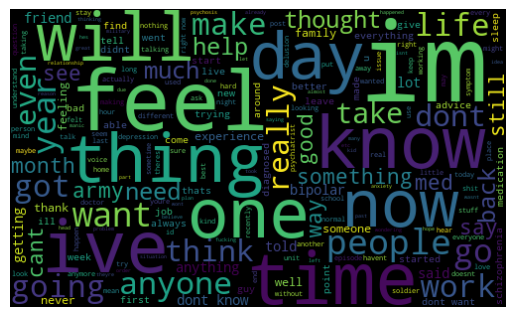

The word cloud is not clear because the groups are together. We need to separate the groups to get a better understanding of the words used in each group.


In [114]:
#Plot Word Cloud
allWords = ' '.join([posts for posts in text_data_df['cleaned_text']])
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print(f'The word cloud is not clear because the groups are together. We need to separate the groups to get a better understanding of the words used in each group.')

### Separate the data into groups

In [115]:
# Variable
groups = text_data_df.groupby('subreddit')

print(groups.size())

subreddit
Army             1264
USMC              448
bipolar           960
schizophrenia     732
dtype: int64


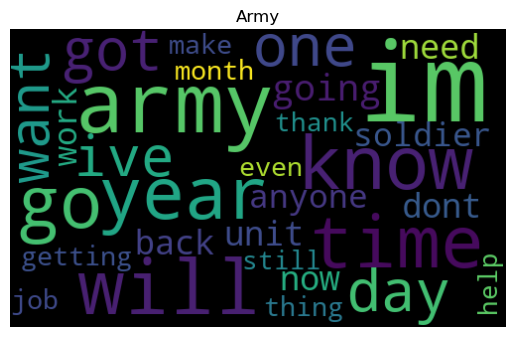

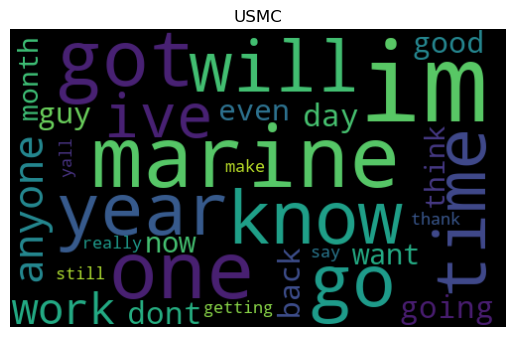

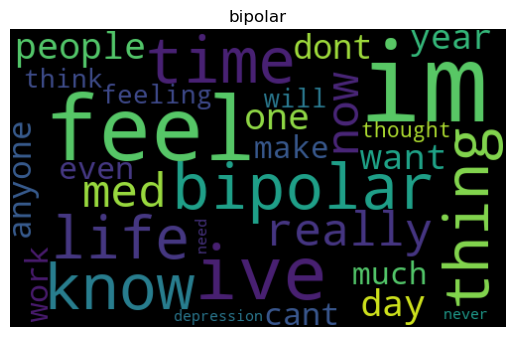

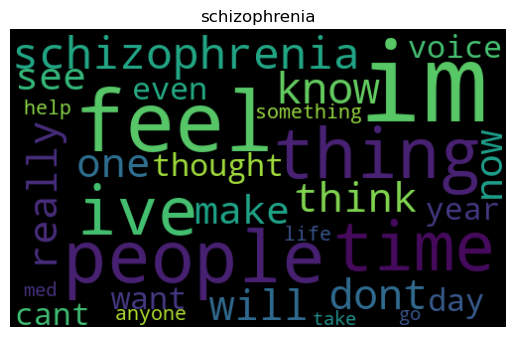

In [116]:
#Word Cloud for each group
for group in groups:
    allWords = ' '.join([posts for posts in group[1]['cleaned_text']])
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=110, max_words=30).generate(allWords)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(group[0])
    plt.show()

## Baseline Sentiment Analysis

### Manually create sentiment labels

In [117]:
#Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
text_data_df['Analysis'] = text_data_df['Polarity'].apply(getAnalysis)    

In [118]:
#Display Positive posts #Ref: www.youtube.com/watch?v=ujId4ipkBio (34:56)
j = 1
sortedDF = text_data_df.sort_values(by=['Polarity'])
sortedDF = sortedDF.reset_index(drop=True)
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['cleaned_text'][i])
        print()
        j = j+1


1) context in the irr so i have medical updates for this form in box i have chronic hemorrhoids induced by some rectal disease a hip labrum tear a hip bone impingement and severe anxiety from recently diagnosed ocd do i have to send in evidence for these illnesses such as paperwork or do i just write the stuff in box or do they send a different form that id have to fill out i have all the documents for my medical issues so it shouldnt be a problem minus the ocd diagnosis because id have to sign a release form for that but im sure it wouldnt be difficult to get also does anyone know what to put in box lastly they sent me this a couple of months ago but i was busy with all my medical issues and put off filling it out til now is there a deadline im supposed to turn this in by edit lastly lastly is there any way to just submit this info online



2) question currently on my rd year at amu for cybersecurity yes a harder path i know but the amount of papers they want is crazy every class wants pretty much a page minimum final paper is anyone else currently at amu that is dealing with this its an online college so i guess i understand but its getting pretty redundant might look into purdue

3) the good the bad and the nutty

4) if so how have it affected your career good or bad cd time promotions needing advice on if i should commit to this rd gig

5) i got laid off today because the biotech company i worked for went bankrupt sorry cancer patients i guess the banks said fuck you have fun without the drugs you need anyway im home having a manic episode and reorganizing my entire wardrobe and bedroom after going and buying some furniture earlier today next i think im going to redo the dining room or living room probably gonna cry in the corner later i just bought a new car and have monthly car payments and no job luckily i have mo

In [119]:
#Display Negative posts #Ref: www.youtube.com/watch?v=ujId4ipkBio (38:56)
j = 1
sortedDF = text_data_df.sort_values(by=['Polarity'], ascending=False)
sortedDF = sortedDF.reset_index(drop=True)
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+ sortedDF['cleaned_text'][i])
        print()
        j = j+1

1) im sure you guys have seen videos of idf clearing rooms and walking through open areas do you think they are well trained they all kinda walk around like they hanging out no stack on doors no caution isnt it too casual

2) tired of stigma tired of being ghosted tired of people asking why my legs are moving so much and if its because im nervous ive chosen to remain alone for life time to buy a dildo and be best friends with it

3) im so lost right now i went through months of mental health treatment a year ago and have been doing well my so has not been and essentially hes been emotionally abusing me bc hes been struggling we moved to a new town and i made a bunch of friends and he has when he leaves the house if i ask him where hes going he asks why im so controlling and tells me i can check on find my friends i feel like if you live with anyone and leave its a basic courtesy to be like hey im leaving ill be back later etc nothing from him ive been really sick the last few days and 

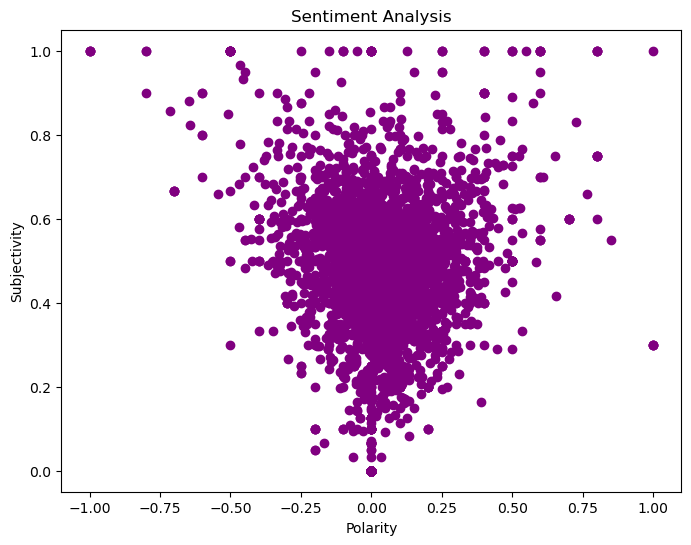

In [120]:
#Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, text_data_df.shape[0]):
    plt.scatter(text_data_df['Polarity'][i], text_data_df['Subjectivity'][i], color='Purple')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show();

In [121]:
#Get the percentage of positive posts
positive_posts = text_data_df[text_data_df.Analysis == 'Positive']
positive_posts = positive_posts['cleaned_text']
round((positive_posts.shape[0] / text_data_df.shape[0]) * 100, 1)

56.6

In [122]:
# Get the percentage of negative posts
negative_posts = text_data_df[text_data_df.Analysis == 'Negative']
negative_posts = negative_posts['cleaned_text']
round((negative_posts.shape[0] / text_data_df.shape[0]) * 100, 1)

33.6

In [123]:
# Get the percentage of neutral posts
neutral_posts = text_data_df[text_data_df.Analysis == 'Neutral']
neutral_posts = neutral_posts['cleaned_text']
round((neutral_posts.shape[0] / text_data_df.shape[0]) * 100, 1)

9.8

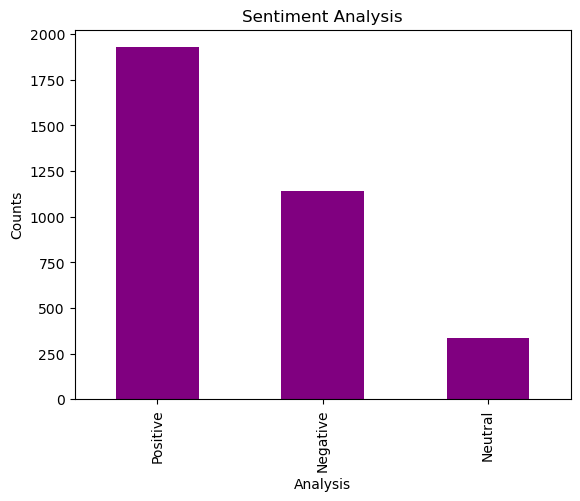

In [138]:
# Value Counts
text_data_df['Analysis'].value_counts()

#Plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
text_data_df['Analysis'].value_counts().plot(kind='bar', color='Purple')
plt.show()


### Calculate the sentiment of each group

In [125]:
subreddit_names = ['Army', 'USMC', 'schizophrenia', 'bipolar']  # Replace with actual subreddit names
subreddit_dfs = {name: text_data_df[text_data_df['subreddit'] == name] for name in subreddit_names}

In [126]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

for subreddit, df in subreddit_dfs.items():
    df['Analysis'] = df['Polarity'].apply(getAnalysis)


/var/folders/67/7hn0hf594mx1nr3d4zql8fg80000gn/T/ipykernel_18860/998039290.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)


#### Army

563) context in the irr so i have medical updates for this form in box i have chronic hemorrhoids induced by some rectal disease a hip labrum tear a hip bone impingement and severe anxiety from recently diagnosed ocd do i have to send in evidence for these illnesses such as paperwork or do i just write the stuff in box or do they send a different form that id have to fill out i have all the documents for my medical issues so it shouldnt be a problem minus the ocd diagnosis because id have to sign a release form for that but im sure it wouldnt be difficult to get also does anyone know what to put in box lastly they sent me this a couple of months ago but i was busy with all my medical issues and put off filling it out til now is there a deadline im supposed to turn this in by edit lastly lastly is there any way to just submit this info online

564) question currently on my rd year at amu for cybersecurity yes a harder path i know but the amount of papers they want is crazy every class w

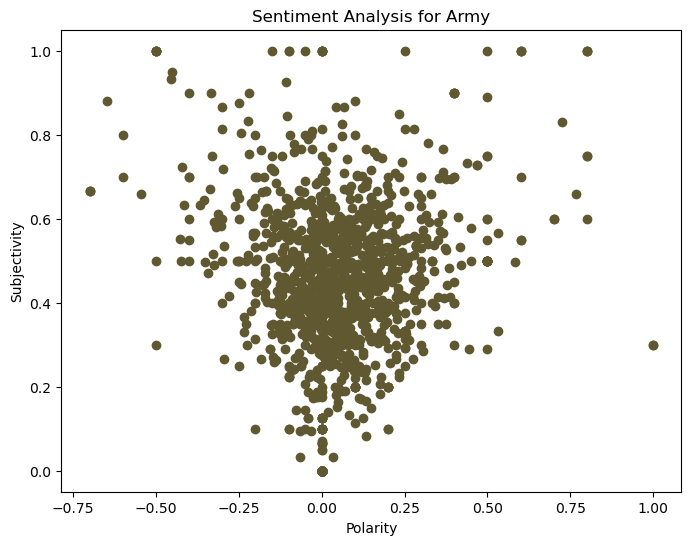

Positive Posts Percentage: 55.5%
Negative Posts Percentage: 32.2%
Neutral Posts Percentage: 12.3%


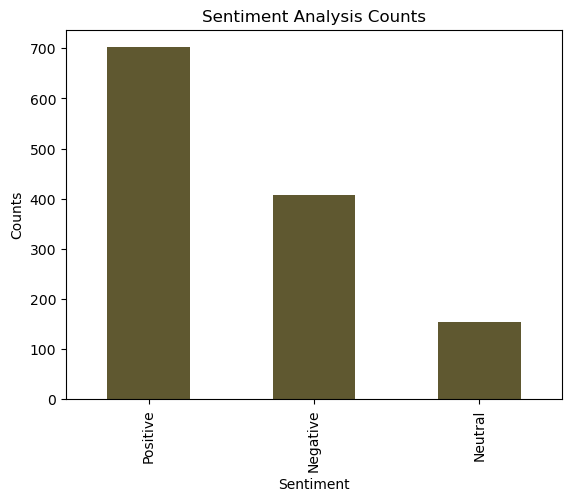

In [141]:
# Example for one subreddit
subreddit_name = 'Army'  # Replace with actual subreddit name
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#5f5830')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#5f5830')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

#### USMC

207) the good the bad and the nutty

208) im applying for skill bridge the company application asked for my gt score which is a i think thats little low and dont want to look like a dummy im unsure if they can check my actual score if they cant im going to lie and say its a like a any advice thanks

209) howdy i would of course like to first state that im only a civilian whos closest experience to anything marine corps is mcjrotc go ahead and make all the jokes you want additionally i do a impressions of a late to early s usmc infantrymen so i atleast have a basic understanding when it comes to dealing with shining jungle boots dealing with alice gear and the inability to sit comfortably in a vehicle with a buttpack in wearing a pasgt helmet and vestetc with that out the way i would like to hear about your folks experience when it comes to equipment loadouts when it comes to field exercisesetc for starters ive seen images with infantry with m gas mask carriers in the field outside of d

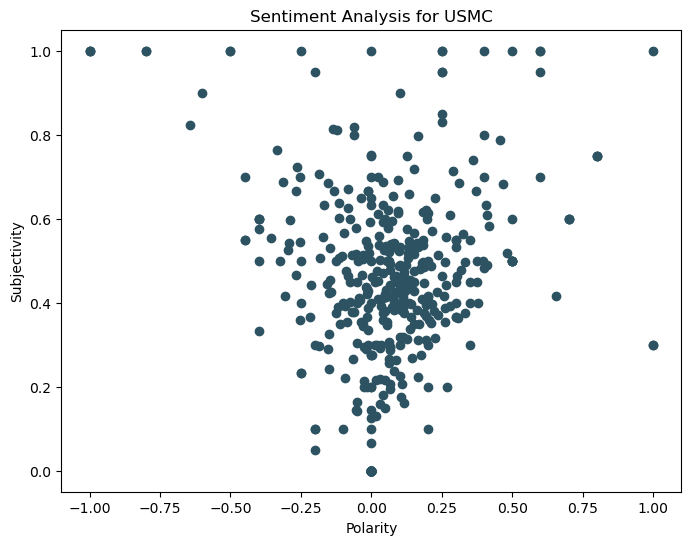

Positive Posts Percentage: 54.0%
Negative Posts Percentage: 28.3%
Neutral Posts Percentage: 17.6%


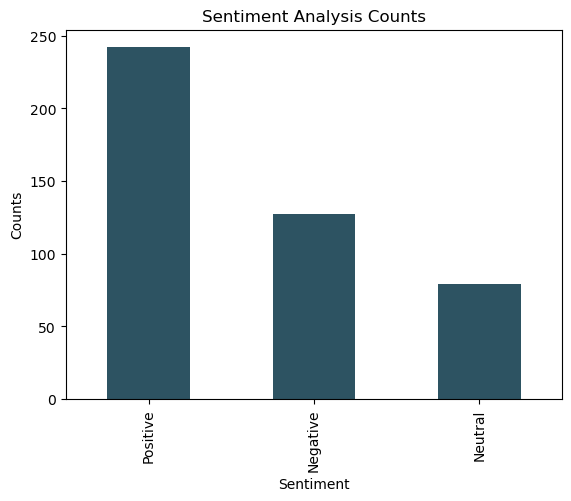

In [137]:
# Subreddit 
subreddit_name = 'USMC' # Replace with subreddit name
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#2d5362')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#2d5362')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

#### Schizophrenia

328) thimk i got infection in stomach from notmcleaningproperly feel bit better snd thinking xlearee on new anti depressanbut think xrack cocainealrwady donedamahnothing ro show foget paid next wsek i hope csn sort things out but dam its not jus clutter its dirt ktndisgusts me so yh timed i been to depressed to go toilet or too fucked and pissed in randomcorner or hadsecrack had shits snd was runnimgroimd house going i a ahorsey and pooping og nhs idnomly yoykmdw the madness in my eyesmi a nitfase in didguise wskeypooen your eyed bzdmove knifeapplierip out thebeye poke the bran

329) ampxb stumbled upon this mans youtube channel gtruth through youtube shorts from his videos and shorts you can tell he is a paranoid schizophrenic gtruth yt cars that pass him are following him or are illuminati paid actors birds following him are controlled by witches strangers walking by are hitmen recording strangers walking by and having verbal altercations with some threating to fight them some stuff 

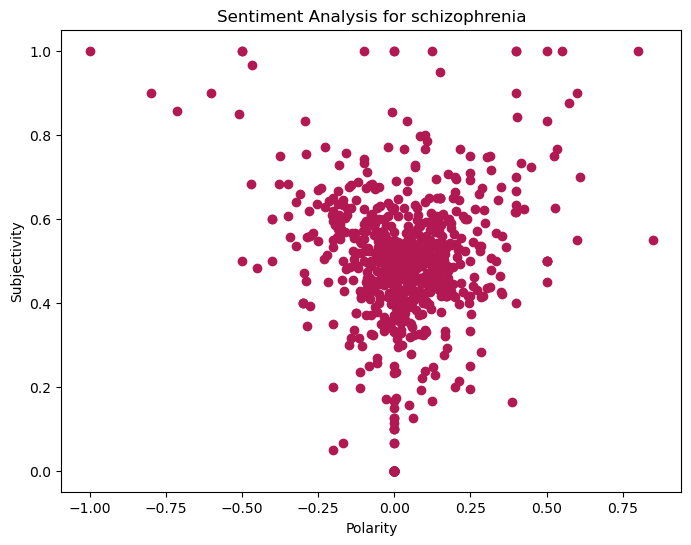

Positive Posts Percentage: 55.3%
Negative Posts Percentage: 33.3%
Neutral Posts Percentage: 11.3%


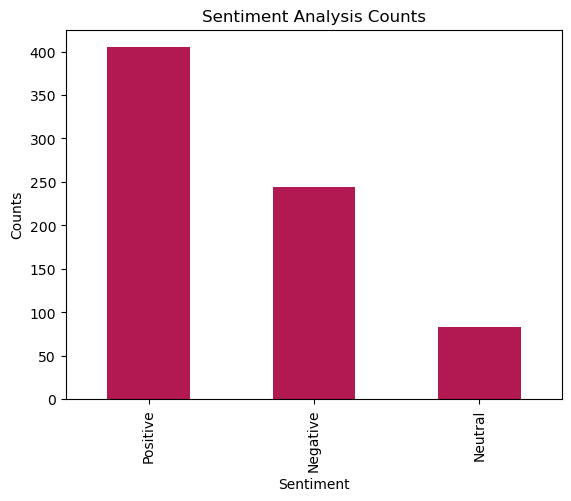

In [142]:
# Example for one subreddit
subreddit_name = 'schizophrenia'  # Replace with actual subreddit name
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#B21852')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#B21852')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

#### Bipolar

382) i got laid off today because the biotech company i worked for went bankrupt sorry cancer patients i guess the banks said fuck you have fun without the drugs you need anyway im home having a manic episode and reorganizing my entire wardrobe and bedroom after going and buying some furniture earlier today next i think im going to redo the dining room or living room probably gonna cry in the corner later i just bought a new car and have monthly car payments and no job luckily i have months of payments saved up so i dont have to dip into my savings but after that who knows what i do next i need to start finding a new job

383) tw abuse violence suicide selfharm tldr very very angry rage any samestories and fix ups man i need to vent and also portray how bad this can change who you are dudes eventhrough i had a traumatic childhood and didnt learn to regulate i did it on my own because i was so effin badass also because it was needed for me to survive ofc also i was in therapy for years 

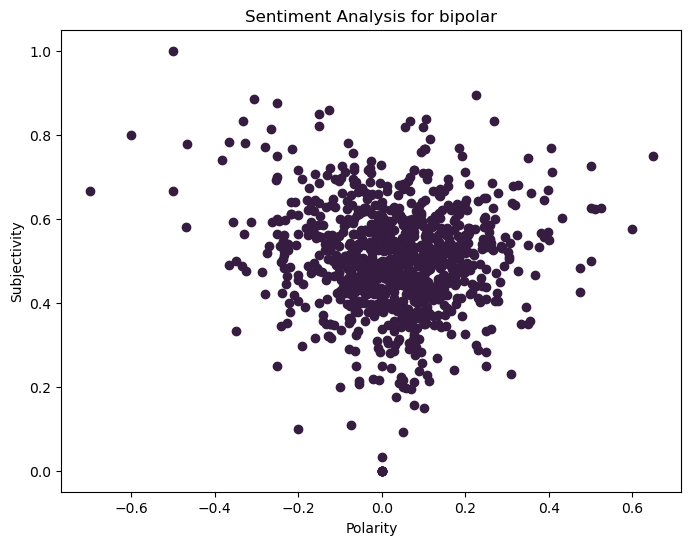

Positive Posts Percentage: 60.3%
Negative Posts Percentage: 38.0%
Neutral Posts Percentage: 1.7%


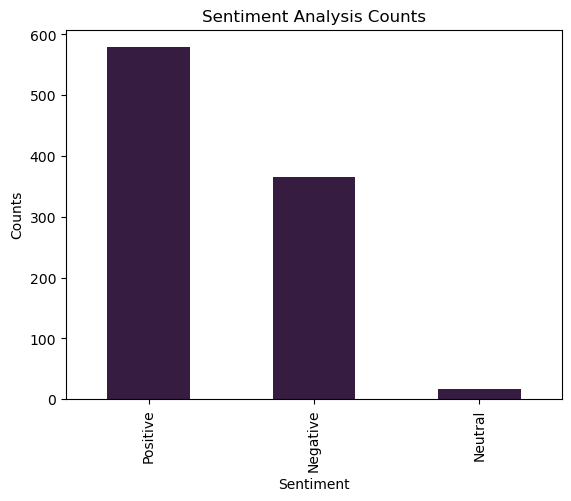

In [143]:
# Example for one subreddit
subreddit_name = 'bipolar'  # Replace with actual subreddit name
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#361c40')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#361c40')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

## BERT Tokenization

In [131]:
#Variables
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased') #Ref: https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#tfbertforsequenceclassification
subreddit_sentiments = {}

def encode_text_for_bert(text, tokenizer, max_length=512):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_length,   # Truncate/pad sentences
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'      # Return numpy tensors
    )

for subreddit, group in tqdm(groups, desc="Processing subreddits"):
    group['encoded_texts'] = group['cleaned_text'].apply(lambda x: encode_text_for_bert(x, tokenizer))

    predictions = []

    for index, row in tqdm(group.iterrows(), total=group.shape[0], desc=f"Predicting for {subreddit}"):
        encoded_dict = row['encoded_texts']
        input_ids = np.array(encoded_dict['input_ids'])
        attention_mask = np.array(encoded_dict['attention_mask'])

        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = tf.nn.softmax(outputs.logits, axis=-1)
        predictions.append(prediction)
    
    # Aggregate the predictions for the current subreddit
    aggregated_prediction = tf.reduce_mean(tf.concat(predictions, axis=0), axis=0)
    subreddit_sentiments[subreddit] = aggregated_prediction.numpy()

# Convert the aggregated sentiments into a DataFrame
sentiment_df = pd.DataFrame.from_dict(subreddit_sentiments, orient='index', columns=['Confidence_Positive', 'Confidence_Negative'])

# Reset the index to make subreddit names a column
sentiment_df.reset_index(inplace=True)
sentiment_df.rename(columns={'index': 'Subreddit'}, inplace=True)

# Display the DataFrame
print(sentiment_df)
    

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing subreddits: 100%|██████████| 4/4 [1:04:47<00:00, 971.82s/it]


       Subreddit  Confidence_Positive  Confidence_Negative
0           Army             0.286871             0.713128
1           USMC             0.294424             0.705576
2        bipolar             0.275409             0.724591
3  schizophrenia             0.274716             0.725284


In [132]:
sentiment_df.to_csv('./data/sentiment_data.csv', index=False)